# Setup

In [14]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [15]:
tf.config.list_physical_devices('GPU')

[]

# Data Preparation

In [16]:
# Environment variable
main_dir = 'D:/Data/HAM100000 - Harvard Dataset'
main_img_dir = main_dir + '/img_data'
preprocessed_data_dir = main_dir + '/preprocessed_data'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'

aug_label = preprocessed_data_dir + '/aug_label.csv'
aug_img_data_dir = main_dir + '/augmented_data'
model_path = 'densenetSoftAtt_10split_LRStr.hdf5'

In [17]:
target_size = (224, 224)
def Get_data(df_path, img_path, _target_size):
    img_list = []
    labels = []
    ages = []
    sex_list = []
    localizations = []
    
    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['image_id'] + '.jpg'))
        labels.append(row['dx'])
        ages.append(float(row['age']))
        sex_list.append(row['sex'])
        localizations.append(row['localization'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size)
        img_list[x] = tf.keras.applications.mobilenet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return (img_list, ages, sex_list, localizations), labels

In [18]:
train_df = pd.read_csv(train_label)
train_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,1,ISIC_0025030,bkl,80.0,male,scalp
1,2,ISIC_0026769,bkl,80.0,male,scalp
2,3,ISIC_0025661,bkl,80.0,male,scalp
3,4,ISIC_0031633,bkl,75.0,male,ear
4,5,ISIC_0027850,bkl,75.0,male,ear


In [19]:
val_df = pd.read_csv(val_label)
val_df.head()

,Unnamed: 0,image_id,dx,age,sex,localization
0,4966,ISIC_0029433,nv,35.0,male,trunk
1,5058,ISIC_0030113,nv,40.0,male,back
2,4321,ISIC_0027962,nv,50.0,female,upper extremity
3,128,ISIC_0032949,bkl,85.0,female,face
4,7739,ISIC_0033229,nv,5.0,female,back


## Training Data

In [20]:
(train_img_lst, train_ages, train_sexes, train_localizations), labels = Get_data(train_label, main_img_dir, target_size)

In [21]:
any(elem is None for elem in train_img_lst)

False

In [22]:
print("Number of images: {}".format(len(train_img_lst)))
print("Image shape: {0} {1}".format(train_img_lst[0].shape[0], train_img_lst[0].shape[1]))
print("Example of Age: {}".format(train_ages[0]))
print("Example of Sex: {}".format(train_sexes[0]))
print("Example of Localization: {}".format(train_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


## Validation Data

In [23]:
(val_img_lst, val_ages, val_sexes, val_localizations), val_labels = Get_data(val_label, main_img_dir, target_size)

In [24]:
any(elem is None for elem in train_img_lst)

False

In [25]:
print("Number of images: {}".format(len(val_img_lst)))
print("Image shape: {0} {1}".format(val_img_lst[0].shape[0], val_img_lst[0].shape[1]))
print("Example of Age: {}".format(val_ages[0]))
print("Example of Sex: {}".format(val_sexes[0]))
print("Example of Localization: {}".format(val_localizations[0]))

Number of images: 996
Image shape: 224 224
Example of Age: 35.0
Example of Sex: male
Example of Localization: trunk


# Augmented Data

In [26]:
(aug_img_lst, aug_ages, aug_sexes, aug_localizations), aug_labels = Get_data(aug_label, aug_img_data_dir, target_size)

In [27]:
any(elem is None for elem in aug_img_lst)

False

In [28]:
print("Number of images: {}".format(len(aug_img_lst)))
print("Image shape: {0} {1}".format(aug_img_lst[0].shape[0], aug_img_lst[0].shape[1]))
print("Example of Age: {}".format(aug_ages[0]))
print("Example of Sex: {}".format(aug_sexes[0]))
print("Example of Localization: {}".format(aug_localizations[0]))

Number of images: 8962
Image shape: 224 224
Example of Age: 80.0
Example of Sex: male
Example of Localization: scalp


# Model

## Input Block

In [29]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32)
sex_input = tf.keras.Input(shape=(1,), name='sex', dtype=tf.string)
localizations_input = tf.keras.Input(shape=(1,), name='localization', dtype=tf.string)

inputs = {'age' : age_input,
         'sex' : sex_input,
         'local' : localizations_input}

In [30]:
norm = layers.Normalization()
norm.adapt(np.array(train_df[['age']]))
age_norm_input = norm(age_input)
age_norm_input

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization')>

In [31]:
# Sex input
sex_lookup = layers.StringLookup(vocabulary=np.unique(train_df['sex']))
sex_one_hot = layers.CategoryEncoding(num_tokens=sex_lookup.vocabulary_size())

preprocessed_sex_input = sex_lookup(sex_input)
preprocessed_sex_input = sex_one_hot(preprocessed_sex_input)
preprocessed_sex_input

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding')>

In [32]:
# Localization input
local_lookup = layers.StringLookup(vocabulary=np.unique(train_df['localization']))
local_one_hot = layers.CategoryEncoding(num_tokens=local_lookup.vocabulary_size())

preprocess_local_input = local_lookup(localizations_input)
preprocess_local_input = local_one_hot(preprocess_local_input)
preprocess_local_input

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_1')>

In [33]:
preprocessed_inputs = [age_norm_input, preprocessed_sex_input, preprocess_local_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

# preprocessed_Model = tf.keras.Model(inputs, preprocessed_inputs_cat)
# tf.keras.utils.plot_model(model = preprocessed_Model , rankdir="LR", dpi=72, show_shapes=True)

preprocessed_inputs_cat

<KerasTensor: shape=(None, 21) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [34]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [35]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [36]:
densenet = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = densenet.input

# Exclude the last 28 layers of the model.
densenet_output = densenet.layers[-28].output

## Final Model

In [37]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(densenet_output.shape[-1]),name='soft_attention')(densenet_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
densenet_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(densenet_output))

densenet_output = layers.Concatenate()([densenet_output, attention_layer])
densenet_output = Activation('relu')(densenet_output)
densenet_output = Dropout(0.5)(densenet_output)

In [38]:
output = Flatten()(densenet_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(7, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Training

In [40]:
feature_dict = {'age' : np.array(train_ages),
                'sex' : np.array(train_sexes),
                'local' : np.array(train_localizations),
                'image' : np.array(train_img_lst)}

In [41]:
val_dict = {'age' : np.array(val_ages),
                'sex' : np.array(val_sexes),
                'local' : np.array(val_localizations),
                'image' : np.array(val_img_lst)}

In [42]:
class_weights = { 
                    0: 4.37,  # akiec
                    1: 2.78,  # bcc
                    2: 1.3,  # bkl
                    3: 12.44,  # df
                    4: 1.28,  # mel
                    5: 0.21,  # nv
                    6: 10,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [43]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [44]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [45]:
batch_size = 32 

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=(len(train_df)/10),
                        epochs=500,
                        validation_data=(val_dict, val_labels), 
                        validation_steps=len(val_df)/batch_size,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/500
896/896 [==============================] - 15622s 17s/step - loss: 1.8299 - accuracy: 0.2026 - val_loss: 1.5222 - val_accuracy: 0.4960 - lr: 0.0010
Epoch 2/500
896/896 [==============================] - 14957s 17s/step - loss: 1.1783 - accuracy: 0.6072 - val_loss: 1.3035 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 3/500
896/896 [==============================] - 15356s 17s/step - loss: 0.7798 - accuracy: 0.6813 - val_loss: 1.5618 - val_accuracy: 0.4468 - lr: 0.0010
Epoch 4/500
896/896 [==============================] - 14987s 17s/step - loss: 0.6327 - accuracy: 0.7074 - val_loss: 1.0179 - val_accuracy: 0.6616 - lr: 0.0010
Epoch 5/500
896/896 [==============================] - 14817s 17s/step - loss: 0.4833 - accuracy: 0.7501 - val_loss: 0.6477 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 6/500
896/896 [==============================] - 14921s 17s/step - loss: 0.3872 - accuracy: 0.7772 - val_loss: 1.6121 - val_accuracy: 0.5161 - lr: 0.0010
Epoch 7/500
896/896 [===================

896/896 [==============================] - 14784s 16s/step - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.4688 - val_accuracy: 0.8775 - lr: 3.2000e-07
Epoch 47/500
896/896 [==============================] - 14858s 17s/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.4703 - val_accuracy: 0.8765 - lr: 3.2000e-07
Epoch 48/500
897/896 [==============================] - ETA: -12s - loss: 0.0031 - accuracy: 0.9988
Epoch 00048: ReduceLROnPlateau reducing learning rate to 1e-07.
896/896 [==============================] - 14923s 17s/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.4674 - val_accuracy: 0.8765 - lr: 3.2000e-07
Epoch 49/500
896/896 [==============================] - 14778s 16s/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.4689 - val_accuracy: 0.8775 - lr: 1.0000e-07
Epoch 50/500
896/896 [==============================] - 14797s 17s/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 0.4677 - val_accuracy: 0.8775 - lr: 1.0000e-07
Epoch 51/500
896/896 [===============

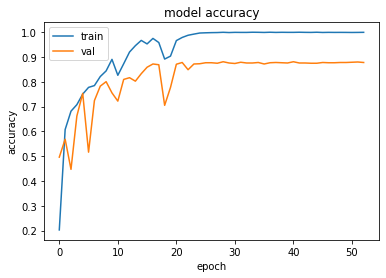

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

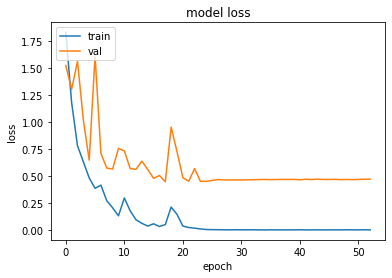

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
from tensorflow.keras import models
model.load_weights(model_path)

In [49]:
predictions = model.predict(val_dict, steps=len(val_df)/batch_size, verbose=0)

In [50]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.74      0.76      0.75        33
         bcc       0.84      0.80      0.82        51
         bkl       0.80      0.74      0.77       109
          df       0.64      0.75      0.69        12
         mel       0.70      0.67      0.69       111
          nv       0.93      0.95      0.94       666
        vasc       1.00      1.00      1.00        14

    accuracy                           0.88       996
   macro avg       0.81      0.81      0.81       996
weighted avg       0.88      0.88      0.88       996



In [51]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.878692350320349
Recall: 0.8805220883534136
Accuracy: 0.8805220883534136
weighted Roc score: 0.969139648499022


In [52]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))

Precision: 0.807697338694296
Recall: 0.8102476727679102
Accuracy: 0.8805220883534136
Macro Roc score: 0.97864831822283


In [53]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.8805220883534136
Recall: 0.8805220883534136
Accuracy: 0.8805220883534136
Micro Roc score: 0.9880214465626899


In [54]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9769029862487807
The ROC AUC score of bcc is: 0.9881834215167549
The ROC AUC score of bkl is: 0.9698292357498216
The ROC AUC score of df is: 0.9947493224932249
The ROC AUC score of mel is: 0.9519315926095587
The ROC AUC score of nv is: 0.9689416689416689
The ROC AUC score of vasc is: 1.0


In [55]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

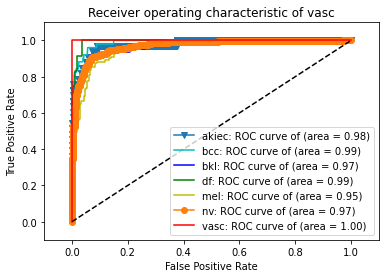

In [56]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()